# Apply greedy modularity [1] Community detection technique on the network

 - Using ['greedy_modularity_communities' from NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities)
 
 [1] Clauset, A., Newman, M. E., & Moore, C. “Finding community structure in very large networks.” Physical Review E 70(6), 2004.

In [42]:

# choosing the Brazilian state (e.g. 'AM-13', 'PA-15', BA-29', 'SP-35', 'RJ-33', 'RS-43')
UF = 'SP'

estado_dict = {'RJ': ['33', 'Rio de Janeiro', '(-43.5,-22.9)', '(-43.7,-23.3)'], 
               'RS': ['43', 'Porto Alegre', '(-51.15,-30.1)', '(-51,-32)'],
               'SP': ['35', 'São Paulo', '(-46.7,-23.5)', '(-46.1, -24.5)'],
               'CE': ['23', 'Fortaleza', '(-38.57, -3.74)', '(-37.53, -3.9)'],
               'BA': ['29', 'Salvador', '(-38.5,-13)', '(-38.5,-14)']}
uf_code = int(estado_dict[UF][0])
capital = estado_dict[UF][1]
xy = eval(estado_dict[UF][2])
xytext = eval(estado_dict[UF][3])

In [43]:
import pandas as pd
import numpy as np
import geopandas as gpd

# import the municipalities shapes
#mun_df = gpd.read_file("../data/%s/%s_mun.shp"%(UF, UF))
mun_df = gpd.read_file("../data/%s/%s_Municipios_%d.dbf"%(UF, UF, 2021))
mun_df['code'] = np.array([item[:-1] for item in np.array(mun_df.CD_MUN)]).astype('int') # trim last char
mun_df['centroid_x'] = mun_df.geometry.centroid.x
mun_df['centroid_y'] = mun_df.geometry.centroid.y
mun_df = mun_df.rename(columns={'NM_MUN': 'name'})

# import the patient flow data
df = pd.read_csv("../data/%s/%s_sih_flow.csv"%(UF, UF))

<ipython-input-43-546e706d7c5a>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mun_df['centroid_x'] = mun_df.geometry.centroid.x
<ipython-input-43-546e706d7c5a>:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mun_df['centroid_y'] = mun_df.geometry.centroid.y


**Removing incoming/outcomming hospitalizations out from the choosen state**

In [44]:
df = df[df['mun_res']>uf_code*10000][df['mun_res']<(uf_code+1)*10000]
df = df[df['mun_cnes']>uf_code*10000][df['mun_cnes']<(uf_code+1)*10000]

<ipython-input-44-f35c2061d4d4>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['mun_res']>uf_code*10000][df['mun_res']<(uf_code+1)*10000]


**Config Greedy modularity and plot methods**

In [45]:
import numpy as np

import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

from palettable.colorbrewer.qualitative import Set1_9, Set2_8, Set3_12

palette = Set1_9.hex_colors + Set2_8.hex_colors + Set3_12.hex_colors


def find_communities(G):
    communities = greedy_modularity_communities(G.to_undirected())
    comm_dict = {}
    for i in range(len(communities)):
        for key in list(communities[i]):
            comm_dict[key] = i
    
    nx.set_node_attributes(G, comm_dict, 'community')
    return comm_dict


def draw_communities(G, title_initial, title_final, save=False):
    communities = [c for c in nx.get_node_attributes(G, 'community').values()]

    color_map = mun_df.shape[0] * ['aqua']
    for municipality, attr in G.nodes(data=True):
        color_map[np.where(mun_df['code'].values == municipality)[0][0]] = palette[attr['community']%len(palette)]

    fig, ax = plt.subplots(figsize=(20, 15))
    fig.set_facecolor('white')
#     regions_shape = gpd.read_file("../data/%s/macroregions.shp"%UF)
    regions_shape = gpd.read_file("../data/%s/regions.shp"%UF)
    regions_shape[regions_shape['year']==2019].plot(ax=ax, facecolor='none', edgecolor='k', zorder=2, lw=5)
    gpd.GeoSeries(mun_df['geometry'].values).plot(ax=ax, color=color_map, edgecolor='white', zorder=1)

    ax.annotate(capital, xy=xy, xytext=xytext, 
                arrowprops=dict(arrowstyle='->', lw=3), fontsize=30)
    
    regions_line = [Line2D([0, 1], [0, 2], color='k', alpha=0.8, lw=5)]
    gray_circle = [Line2D(range(1), range(1), color='w', marker='o', markerfacecolor='aqua', ms=15, mec='gray')]

#     plt.legend(regions_line, ['Limites das macroregiões de saúde'], bbox_to_anchor=(1, 0.02), fontsize = '42')
    plt.legend(regions_line, ['Limites das regiões de saúde'], bbox_to_anchor=(1, 0.02), fontsize = '42')
#     plt.legend(regions_line+gray_circle, ['Limites das regiões de saúde', 'Municípios sem dados de fluxos para o período'], loc=3, fontsize = '24')
#     plt.legend(regions_line+gray_circle, ['Limits of Health Regions', 'Municipalities without flow data'], loc=3, fontsize = '24')
    
#     plt.suptitle(title_initial, fontsize=38)
    plt.title('Comunidades detectadas pelo '+r"$\bf{greedy}$"+ '\n' + r"$\bf{modularity}$" +title_initial+'('+str(max(communities)+1)+ ' comunidades)', fontsize = '52')
#     plt.title('Detected '+str(max(communities)+1)+' communities using \nGreedy modularity network clustering algorithm'+title_final, fontsize = '28')
    plt.axis('off')
    if save: 
#         plt.savefig("/home/gabriely/Mestrado/dissertacao/figuras/macro_modularity_%s_2019.png"%UF.lower(), bbox_inches='tight')
        plt.savefig("/home/gabriely/Mestrado/dissertacao/figuras/modularity_%s_2019.png"%UF.lower(), bbox_inches='tight')
        #plt.savefig("../data/%s/images/modularity/%dto%d.png"%(UF, init_year, init_year+4), bbox_inches='tight')
    else: plt.show()

**Saving plots as .png**

In [46]:
# for init_year in range(1994, 2016):
#     flows = df[df['year']>=init_year][df['year']<init_year+5]

#     # Summing the hospitalizations for all years
#     flows = flows[['uf_code', 'mun_cnes', 'mun_res', 'nhospadm_total']].groupby(
#         by = ['uf_code', 'mun_cnes', 'mun_res'], as_index = False).sum()


#     graph = nx.from_pandas_edgelist(flows, source = 'mun_res', target = 'mun_cnes',
#                             edge_attr = 'nhospadm_total', create_using = nx.DiGraph())

#     find_communities(graph)

#     title_initial = '   %d to %d\n'%(init_year, init_year+5)
#     title_final = '\nconsidering all '+str(flows.shape[0])+' flows'
#     draw_communities(graph, title_initial, title_final, save=True)

## Directed and weighted network:

**Group and sum flow data every 5 years (from 1994-2019)**

In [47]:
init_year = 2019

flows = df[df['year']==init_year]

#flows = df[df['year']>=init_year][df['year']<init_year+5]
# # Summing the hospitalizations for all years
# flows = flows[['uf_code', 'mun_cnes', 'mun_res', 'nhospadm_total']].groupby(
#     by = ['uf_code', 'mun_cnes', 'mun_res'], as_index = False).sum()

In [48]:
flows

year  uf_code  mun_cnes   mun_res  nhospadm_total
375735  2019       35    350010  350010.0          2738.0
375736  2019       35    350010  350140.0             3.0
375737  2019       35    350010  350150.0             4.0
375738  2019       35    350010  350335.0             5.0
375739  2019       35    350010  350400.0            71.0
...      ...      ...       ...       ...             ...
393207  2019       35    355720  352090.0             5.0
393208  2019       35    355720  353470.0             3.0
393209  2019       35    355720  354640.0             2.0
393210  2019       35    355720  355030.0             1.0
393211  2019       35    355720  355720.0          1087.0

[11896 rows x 5 columns]

In [49]:
graph = nx.from_pandas_edgelist(flows, source = 'mun_res', target = 'mun_cnes',
                                    create_using = nx.Graph())

comm_dict = find_communities(graph)

In [50]:
greedy_result = pd.DataFrame(comm_dict.items(), columns=['mun_code', 'community'])
mun_df = mun_df.merge(greedy_result, how = 'left', left_on = ['code'], right_on = ['mun_code'])

mun_df[['code', 'community']]

code  community
0    350010          0
1    350020          0
2    350030          1
3    350040          1
4    350050          1
..      ...        ...
640  355700          1
641  355710          0
642  355715          0
643  355720          0
644  355730          1

[645 rows x 2 columns]

In [35]:
# mun_df[['code', 'community']].to_csv("./greedy_result_%d.csv"%init_year, index=False)

---------------

In [28]:

# # choosing the Brazilian state (e.g. 'AM-13', 'PA-15', BA-29', 'SP-35', 'RJ-33', 'RS-43')
# UF = 'CE'

# estado_dict = {'RJ': ['33', 'Rio de Janeiro', '(-43.5,-22.9)', '(-43.7,-23.3)'], 
#                'RS': ['43', 'Porto Alegre', '(-51.15,-30.1)', '(-51,-32)'],
#                'SP': ['35', 'São Paulo', '(-46.7,-23.5)', '(-46.1, -24.5)'],
#                'CE': ['23', 'Fortaleza', '(-38.57, -3.74)', '(-37.53, -3.9)'],
#                'BA': ['29', 'Salvador', '(-38.5,-13)', '(-38.5,-14)']}
# uf_code = int(estado_dict[UF][0])
# capital = estado_dict[UF][1]
# xy = eval(estado_dict[UF][2])
# xytext = eval(estado_dict[UF][3])

# import pandas as pd
# import geopandas as gpd
# import numpy as np
# import networkx as nx
# from networkx.algorithms.community import greedy_modularity_communities
# from sklearn.metrics.cluster import v_measure_score


# # import the municipalities shapes
# #mun_df = gpd.read_file("../data/%s/%s_mun.shp"%(UF, UF))
# mun_df = gpd.read_file("../data/%s/%s_Municipios_%d.dbf"%(UF, UF, 2021))
# mun_df['code'] = np.array([item[:-1] for item in np.array(mun_df.CD_MUN)]).astype('int') # trim last char
# mun_df['centroid_x'] = mun_df.geometry.centroid.x
# mun_df['centroid_y'] = mun_df.geometry.centroid.y
# mun_df = mun_df.rename(columns={'NM_MUN': 'name'})

# index_df = pd.DataFrame({'year': df['year'].unique(),
#                          'all': ['']*len(df['year'].unique())}).set_index('year')

# communities_gdf = gpd.GeoDataFrame({'year': [''],
#                                     'geometry': ['']}, index=[0]) 

# # import the municipality-region-macroregion relations
# reg_macro_df = pd.read_csv("../data/%s/reg_macro_table.csv"%UF)

# # import the patient flow data
# df = pd.read_csv("../data/%s/%s_sih_flow.csv"%(UF, UF))

# df = df[df['mun_res']>uf_code*10000][df['mun_res']<(uf_code+1)*10000]
# df = df[df['mun_cnes']>uf_code*10000][df['mun_cnes']<(uf_code+1)*10000]


# def find_communities(G):
#     communities = greedy_modularity_communities(G.to_undirected())
#     comm_dict = {}
#     for i in range(len(communities)):
#         for key in list(communities[i]):
#             comm_dict[key] = i
    
#     nx.set_node_attributes(G, comm_dict, 'community')
#     return comm_dict

# for year in [2019]: #range(1994, 2021)

#     year_df = df[df['year']==year]
#     graph = nx.from_pandas_edgelist(year_df, source = 'mun_res', target = 'mun_cnes',
#                                         create_using = nx.Graph())

#     comm_dict = find_communities(graph)

#     available_year = year
#     if year < 2011: available_year = 2011
#     if year > 2017: available_year = 2017
    
#     year_reg_macro_df = reg_macro_df[reg_macro_df['year']==available_year]
#     R = {row['code']:row['region'] for _, row in year_reg_macro_df.sort_values(by='code').iterrows()}

#     for code in year_reg_macro_df[year_reg_macro_df['code'].isin(year_df['mun_res'].unique())==False]['code']:
#         R.pop(code, None)

#     index = v_measure_score(list(R.values()), list(comm_dict.values()))*100
#     index_name = 'V-Measure'

#     print(year, index)
#     index_df.loc[int(year), 'all'] = index
    
#     greedy_result = pd.DataFrame(comm_dict.items(), columns=['mun_code', 'community'])
#     mun_df = mun_df.merge(greedy_result, how = 'left', left_on = ['code'], right_on = ['mun_code'])
#     dissolved = mun_df[['community', 'geometry']].dissolve(by='community')
#     dissolved['year'] = int(year)

#     print(year, len(greedy_result['community'].unique()), 'communities')
#     communities_gdf = pd.concat([communities_gdf, dissolved[['year', 'geometry']]], axis=0, sort=False, ignore_index=True)
# #     communities_gdf = dissolved[['year', 'geometry']]
#     mun_df = mun_df.drop(columns=['mun_code'])

#     communities_gdf = communities_gdf[1:]
#     reg_df = mun_df.merge(pd.DataFrame(R.values(), R.keys(), columns=['region']), how = 'left', left_on = ['code'], right_index=True)[['region', 'geometry']].dissolve(by='region')
    

<ipython-input-28-445bcff012a5>:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mun_df['centroid_x'] = mun_df.geometry.centroid.x
<ipython-input-28-445bcff012a5>:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mun_df['centroid_y'] = mun_df.geometry.centroid.y
<ipython-input-28-445bcff012a5>:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['mun_res']>uf_code*10000][df['mun_res']<(uf_code+1)*10000]


2019 9.258488474005201
2019 4 communities


In [29]:
reg_df

geometry
region                                                                                 
10<U+1D43>  Região Limoeiro do Norte  POLYGON ((-38.15930 -5.92458, -38.16001 -5.924...
11<U+1D43>  Região Sobral             POLYGON ((-40.05950 -4.71681, -40.11989 -4.748...
12<U+1D43>  Região Aracaú             POLYGON ((-39.93422 -3.31572, -39.93436 -3.316...
13<U+1D43>  Região Tianguá            POLYGON ((-40.80248 -4.34519, -40.80271 -4.345...
14<U+1D43>  Região Tauá               POLYGON ((-40.08411 -6.36741, -40.08436 -6.368...
15<U+1D43>  Região Crateús            POLYGON ((-40.56526 -5.84073, -40.56546 -5.840...
16<U+1D43>  Região Camocim            POLYGON ((-40.49502 -3.06203, -40.50928 -3.108...
17<U+1D43>  Região Icó                POLYGON ((-38.65241 -6.75708, -38.65268 -6.757...
18<U+1D43>  Região Iguatú             POLYGON ((-39.28132 -6.52576, -39.28363 -6.527...
19<U+1D43>  Região Brejo Santo        POLYGON ((-38.96602 -7.84563, -38.96617 -7.845...
1<U+1D43> Região Fortaleza            POLYGON ((-38.40177 -3.82376, -38.40108 -3.823...
20<U+1D43>  Região Crato              POLYGON ((-39.45233 -7.00929, -39.45240 -7.010...
21<U+1D43>  Região Juazeiro do Norte  POLYGON ((-39.09740 -7.61015, -39.07255 -7.626...
22<U+1D43>  Região Cascavel           POLYGON ((-38.36038 -4.50147, -38.36073 -4.501...
2<U+1D43> Região Caucaia              POLYGON ((-39.32423 -4.09023, -39.36945 -4.089...
3<U+1D43> Região Maracanaú            POLYGON ((-38.57047 -4.23548, -38.56723 -4.250...
4<U+1D43> Região Baturité             POLYGON ((-38.76571 -4.62324, -38.76652 -4.624...
5<U+1D43> Região Canindé              POLYGON ((-39.62883 -5.04300, -39.63052 -5.046...
6<U+1D43> Região Itapipoca            POLYGON ((-39.71312 -3.65499, -39.78136 -3.642...
7<U+1D43> Região Aracati              POLYGON ((-37.48511 -4.63996, -37.47973 -4.645...
8<U+1D43> Região Quixadá              POLYGON ((-38.91105 -5.45551, -38.90892 -5.456...
9<U+1D43> Região Russas               POLYGON ((-38.73449 -5.19754, -38.73432 -5.197...

In [30]:
communities_gdf

year                                           geometry
1  2019  POLYGON ((-38.15930 -5.92458, -38.16001 -5.924...
2  2019  POLYGON ((-38.96602 -7.84563, -38.96617 -7.845...
3  2019  MULTIPOLYGON (((-40.16004 -5.16479, -40.15742 ...
4  2019  MULTIPOLYGON (((-38.56042 -5.74593, -38.56037 ...

(-41.63206097724997,
 -37.04411567574995,
 -8.111875421299928,
 -2.5306305146999364)

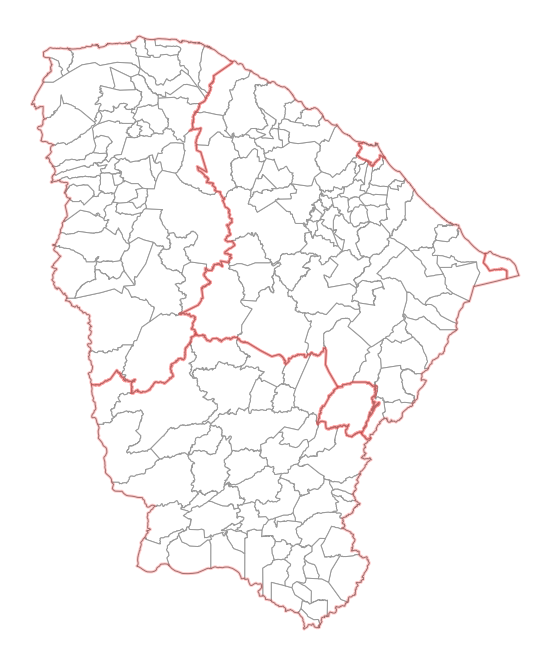

In [34]:
import matplotlib.pyplot as plt

# plot the health regions shape
fig, ax = plt.subplots(figsize=(22, 12))
gpd.GeoSeries(mun_df['geometry']).plot(ax=ax, color="w", edgecolor="grey", lw=1)
# gpd.GeoSeries(reg_df['geometry']).plot(ax=ax, color="w", alpha=0.5, linestyle='-', edgecolor="b", lw=3)
gpd.GeoSeries(communities_gdf['geometry']).plot(ax=ax, color="w", alpha=0.2, linestyle='-', edgecolor="r", lw=3)
# gpd.GeoSeries(gpd.read_file("../data/%s/state.shp"%(UF))['geometry']).plot(ax=ax, color="w", alpha=0.1, linestyle='-', edgecolor="r", lw=3)
ax.axis("off")

-------------------------------

In [51]:
# title_initial = '   %d to %d\n'%(init_year, init_year+4)
# title_initial = '\nutilizando todos os %d fluxos\n'%(flows.shape[0])
title_initial = ' para os dados de %d\n'%(init_year)
# title_final = '\nconsidering all '+str(flows.shape[0])+' flows'
draw_communities(graph, title_initial, '', save=True)

**Testing V-Measure partitions comparator**

 - Using ['scikit learn' python module](https://scikit-learn.org/stable/index.html)

In [60]:
from sklearn.metrics.cluster import completeness_score, homogeneity_score, v_measure_score

# import regions and municipalities relation
reg_mun_df = pd.read_csv('../data/%s/regions/%s_regions_table.csv'%(UF, UF)).sort_values(by='CD_MUN')

# get regions and municipalities relation arrays
R = {mun[0]:mun[1] for mun in reg_mun_df.values}

C = {key:comm_dict[key] for key in sorted(comm_dict)}

v_measure_score(list(R.values()), list(C.values()))*100

44.41110656487706

In [61]:
completeness_score(list(R.values()), list(C.values()))*100

87.64376071824614

In [62]:
homogeneity_score(list(R.values()), list(C.values()))*100

29.74070156813868